# Temporal Segmentation

### Librosa packages

##### librosa.segment.agglomerative(data, k, *, clusterer=None, axis=- 1)

Parameters: 

1) data: np.ndarray (data to cluster)
2) k: int > 0 (number of segments to produce)
3) clusterersklearn.cluster.AgglomerativeClustering, optional (An optional AgglomerativeClustering object. If None, a constrained Ward object is instantiated.)
4) axis: int (axis along which to cluster. By default, the last axis (-1) is chosen.)

Returns:

1) boundaries: np.ndarray [shape=(k,)] (left-boundaries (frame numbers) of detected segments. This will always include 0 as the first left-boundary.)

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import librosa as lb
import matplotlib.transforms as mpt
from librosa import display

In [22]:
y, sr = lb.load('/Users/rajeshr/Desktop/TestSong.wav', duration=15)
chroma = lb.feature.chroma_cqt(y=y, sr=sr)
bounds = lb.segment.agglomerative(chroma, 25)
bound_times = lb.frames_to_time(bounds, sr=sr)
print(bounds, bound_times)

[  0  12  58  72  98 126 159 175 213 230 254 282 317 321 342 370 423 475
 490 514 525 535 575 593 632] [ 0.          0.27863946  1.34675737  1.67183673  2.27555556  2.92571429
  3.69197279  4.06349206  4.94585034  5.34058957  5.89786848  6.54802721
  7.36072562  7.45360544  7.94122449  8.59138322  9.82204082 11.02947846
 11.37777778 11.93505669 12.19047619 12.42267574 13.35147392 13.76943311
 14.67501134]


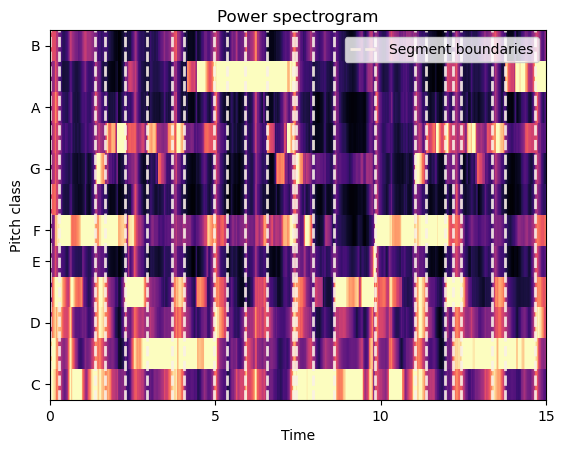

In [23]:
fig, ax = plt.subplots()
trans = mpt.blended_transform_factory(ax.transData, ax.transAxes)
lb.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
ax.vlines(bound_times, 0, 1, color='linen', linestyle='--', linewidth=2, alpha=0.9, label='Segment boundaries',transform=trans)
ax.legend()
ax.set(title='Power spectrogram')
plt.savefig('/Users/rajeshr/Desktop/segemnted_boundaries.png')
plt.show()

##### librosa.segment.subsegment(data, frames, *, n_segments=4, axis=- 1)[source]

Parameters:
1) data: np.ndarray (Data matrix to use in clustering)
2) frames: np.ndarray [shape=(n_boundaries,)], dtype=int, non-negative] (Array of beat or segment boundaries, as provided by librosa.beat.beat_track, librosa.onset.onset_detect, or agglomerative.)
3) n_segments: int > 0 (Maximum number of frames to sub-divide each interval.)
4) axis: int (Axis along which to apply the segmentation. By default, the last index (-1) is taken.)

Returns:
1) boundaries: np.ndarray [shape=(n_subboundaries,)] (List of sub-divided segment boundaries)



In [24]:
y, sr = lb.load('/Users/rajeshr/Desktop/TestSong.wav', duration=15)
tempo, beats = lb.beat.beat_track(y=y, sr=sr, hop_length=512)
beat_times = lb.frames_to_time(beats, sr=sr, hop_length=512)
cqt = np.abs(lb.cqt(y, sr=sr, hop_length=512))
subseg = lb.segment.subsegment(cqt, beats, n_segments=2)
subseg_t = lb.frames_to_time(subseg, sr=sr, hop_length=512)

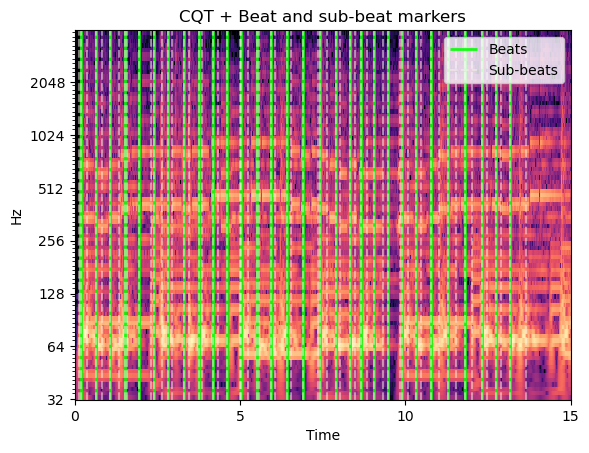

In [25]:
fig, ax = plt.subplots()
lb.display.specshow(lb.amplitude_to_db(cqt, ref=np.max), y_axis='cqt_hz', x_axis='time', ax=ax)
lims = ax.get_ylim()
ax.vlines(beat_times, lims[0], lims[1], color='lime', alpha=0.9, linewidth=2, label='Beats')
ax.vlines(subseg_t, lims[0], lims[1], color='linen', linestyle='--', linewidth=1.5, alpha=0.5, label='Sub-beats')
ax.legend()
ax.set(title='CQT + Beat and sub-beat markers')
plt.savefig('/Users/rajeshr/Desktop/sub_beat.png')
plt.show()

# Recurrence & Affinity Matrix
##### librosa.segment.recurrence_matrix(data, *, k=None, width=1, metric='euclidean', sym=False, sparse=False, mode='connectivity', bandwidth=None, self=False, axis=- 1)

In [26]:
y, sr = lb.load('/Users/rajeshr/Desktop/TestSong.wav')
hop_length = 1024
chroma = lb.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)

# Use time-delay embedding to get a cleaner recurrence matrix
chroma_stack = lb.feature.stack_memory(chroma, n_steps=10, delay=3)

R = lb.segment.recurrence_matrix(chroma_stack)

In [27]:
R_aff = lb.segment.recurrence_matrix(chroma_stack, metric='cosine', mode='affinity')

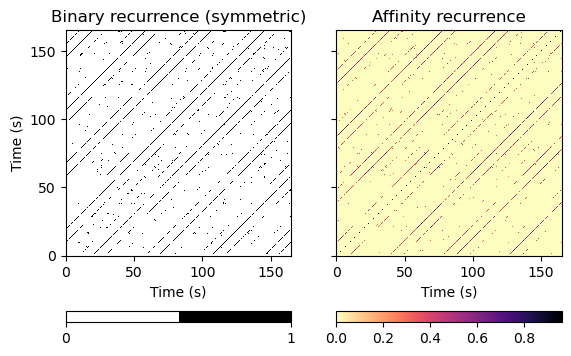

In [29]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
imgsim = lb.display.specshow(R, x_axis='s', y_axis='s', hop_length=hop_length, ax=ax[0])
ax[0].set(title='Binary recurrence (symmetric)')
imgaff = lb.display.specshow(R_aff, x_axis='s', y_axis='s', hop_length=hop_length, cmap='magma_r', ax=ax[1])
ax[1].set(title='Affinity recurrence')
ax[1].label_outer()
fig.colorbar(imgsim, ax=ax[0], orientation='horizontal', ticks=[0, 1])
fig.colorbar(imgaff, ax=ax[1], orientation='horizontal')
plt.savefig('/Users/rajeshr/Desktop/recurrence.png')
plt.show()

# Pairwise frame similarity
##### librosa.segment.cross_similarity(data, data_ref, *, k=None, metric='euclidean', sparse=False, mode='connectivity', bandwidth=None)

In [36]:
hop_length = 1024
y_ref, sr = lb.load('/Users/rajeshr/Desktop/TheBeatlesComeTogether.wav')
y_comp, sr = lb.load('/Users/rajeshr/Desktop/TheBeatlesComeTogether.wav', offset=10)
chroma_ref = lb.feature.chroma_cqt(y=y_ref, sr=sr, hop_length=hop_length)
chroma_comp = lb.feature.chroma_cqt(y=y_comp, sr=sr, hop_length=hop_length)
# Use time-delay embedding to get a cleaner recurrence matrix
x_ref = lb.feature.stack_memory(chroma_ref, n_steps=10, delay=3)
x_comp = lb.feature.stack_memory(chroma_comp, n_steps=10, delay=3)

In [37]:
xsim = lb.segment.cross_similarity(x_comp, x_ref, metric='cosine')

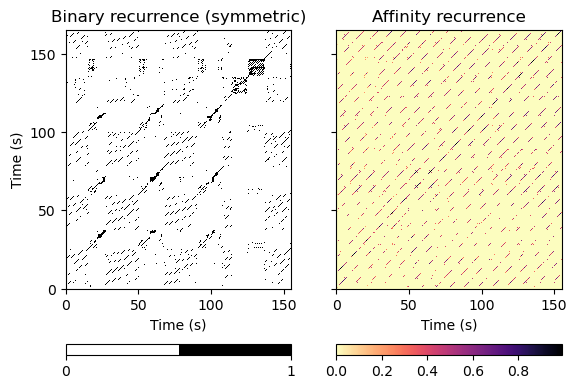

In [38]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
imgsim = lb.display.specshow(xsim, x_axis='s', y_axis='s', hop_length=hop_length, ax=ax[0])
ax[0].set(title='Binary recurrence (symmetric)')
imgaff = lb.display.specshow(xsim_aff, x_axis='s', y_axis='s', cmap='magma_r', hop_length=hop_length, ax=ax[1])
ax[1].set(title='Affinity recurrence')
ax[1].label_outer()
fig.colorbar(imgsim, ax=ax[0], orientation='horizontal', ticks=[0, 1])
fig.colorbar(imgaff, ax=ax[1], orientation='horizontal')
plt.savefig('/Users/rajeshr/Desktop/pairwise_similarity.png')
plt.show()

<Figure size 640x480 with 0 Axes>

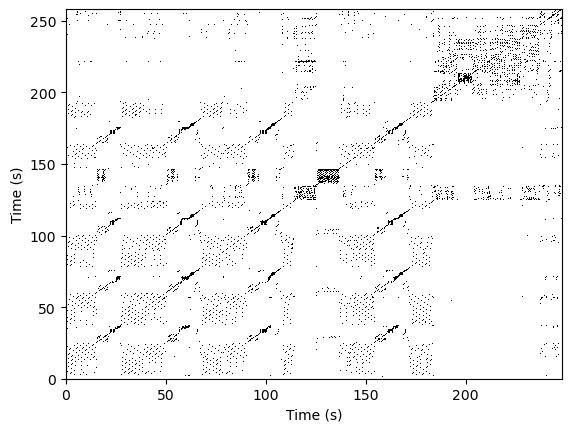

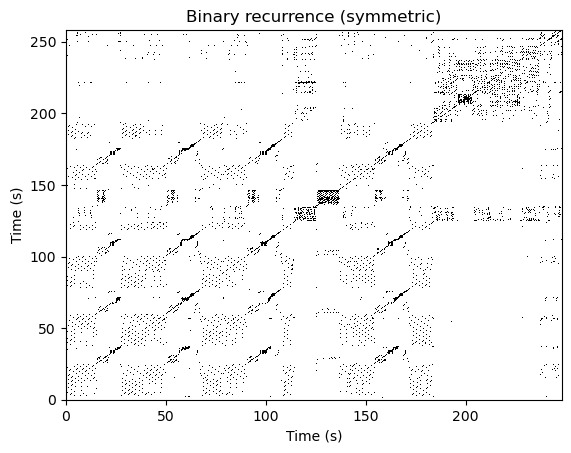

In [48]:
fig = plt.figure()
imgsim = lb.display.specshow(xsim, x_axis='s', y_axis='s', hop_length=hop_length)
plt.title('Binary recurrence (symmetric)')
plt.savefig('/Users/rajeshr/Desktop/pairwise_similarity_1.png')
plt.show()

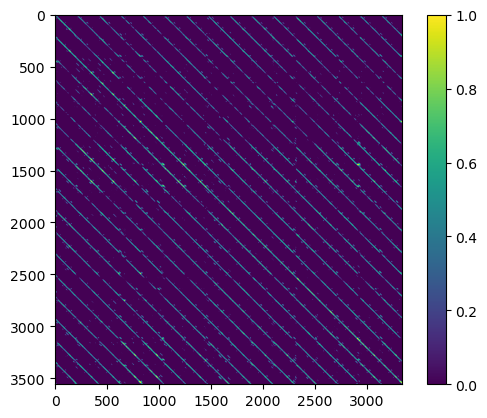

In [16]:
plt.imshow(xsim)
plt.colorbar()
plt.show()

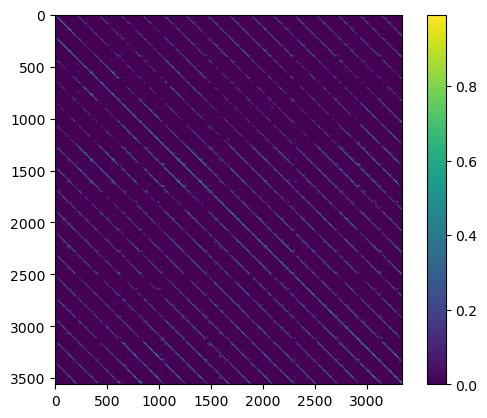

In [17]:
xsim_aff = lb.segment.cross_similarity(x_comp, x_ref, metric='cosine', mode='affinity')
plt.imshow(xsim_aff)
plt.colorbar()
plt.show()